In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

## a standard Logistic regression
https://laurentperrinet.github.io/sciblog/posts/2021-12-12-logistic-regression.html

### generative model for the data

In [54]:
N = 256 # number of factors
n_classes = 10 # number of classes
N_batch = 4
seed = 1973 # release year of https://en.wikipedia.org/wiki/Ring_Ring_(ABBA_song)

np.random.seed(seed)
W = np.random.randn(N+1, n_classes) # FIXED design matrix

def psychometric_function(W, factors):
    # print(W.shape, factors.shape)
    logit = (factors @ W[:-1, :]) + W[-1, :]
    return 1 / (1 + np.exp(-logit))

def get_data(W, seed, N_batch):
    N, n_classes = W.shape[0]-1, W.shape[1]
    np.random.seed(seed)
    factors = np.random.randn(N_batch, N)
    p = psychometric_function(W, factors)
    y = p > np.random.rand(N_batch, n_classes)  # generate data
    return factors, p, y

factors = np.random.randn(N_batch, N)
factors.shape

(4, 256)

In [56]:
y.shape, N_batch

((10000, 10), 4)

### inference model

In [3]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
# see https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html#pytorch-loss-input-confusion-cheatsheet
criterion = torch.nn.BCELoss(reduction="mean") # loss divided by output size
#criterion = torch.nn.NLLLoss(reduction="mean") # loss divided by output size

class LogisticRegressionModel(torch.nn.Module):
    #torch.nn.Module -> Base class for all neural network modules
    def __init__(self, N, n_classes, bias=True):
        super(LogisticRegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(N, n_classes, bias=bias)
        # self.nl = torch.nn.LogSoftmax(n_classes)
        self.nl = torch.nn.Sigmoid()

    def forward(self, factors):
        return self.nl(self.linear(factors))

/opt/homebrew/lib/python3.11/site-packages/torch/__init__.py:615: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [26]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1
batch_size = 256
n_classes=10
amsgrad = True  # gives similar results
amsgrad = False # gives similar results

def fit_data(factors, y, 
            learning_rate=learning_rate,
            batch_size=batch_size,  # gamma=gamma,
            num_epochs=num_epochs,
            betas=betas,
            verbose=False, **kwargs
        ):

    X, labels = torch.Tensor(factors[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(X, labels), batch_size=batch_size, shuffle=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    N_batch = factors.shape[0]
    N = factors.shape[1]
    n_classes = y.shape[1]
    logistic_model = LogisticRegressionModel(N, n_classes)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for X_, labels_ in loader:
            X_, labels_ = X_.to(device), labels_.to(device)
            outputs = logistic_model(X_)
            loss = criterion(outputs, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    logistic_model.eval()
    X, labels = torch.Tensor(factors[:, None]), torch.Tensor(y[:, None])
    outputs = logistic_model(X)
    loss = criterion(outputs, labels).item()
    return logistic_model, loss


factors, p, y = get_data(W, seed=seed, N_batch=10000)
logistic_model, loss = fit_data(factors, y, verbose=True)
print("Final loss =", loss)

(257, 10) (10000, 256)
Iteration: 0 - Loss: 0.51636
Iteration: 16 - Loss: 0.11765
Iteration: 32 - Loss: 0.09548
Iteration: 48 - Loss: 0.08715
Iteration: 64 - Loss: 0.07998
Iteration: 80 - Loss: 0.07838
Iteration: 96 - Loss: 0.07634
Iteration: 112 - Loss: 0.07440
Iteration: 128 - Loss: 0.07364
Iteration: 144 - Loss: 0.07401
Iteration: 160 - Loss: 0.07278
Iteration: 176 - Loss: 0.07134
Iteration: 192 - Loss: 0.07057
Iteration: 208 - Loss: 0.07041
Iteration: 224 - Loss: 0.07118
Iteration: 240 - Loss: 0.06989
Iteration: 256 - Loss: 0.07129
Iteration: 272 - Loss: 0.07028
Iteration: 288 - Loss: 0.07074
Iteration: 304 - Loss: 0.07079
Iteration: 320 - Loss: 0.07061
Iteration: 336 - Loss: 0.07041
Iteration: 352 - Loss: 0.06959
Iteration: 368 - Loss: 0.06866
Iteration: 384 - Loss: 0.07056
Iteration: 400 - Loss: 0.06869
Iteration: 416 - Loss: 0.07027
Iteration: 432 - Loss: 0.06897
Iteration: 448 - Loss: 0.06947
Iteration: 464 - Loss: 0.06891
Iteration: 480 - Loss: 0.06865
Iteration: 496 - Loss: 0

Text(0, 0.5, 'factors')

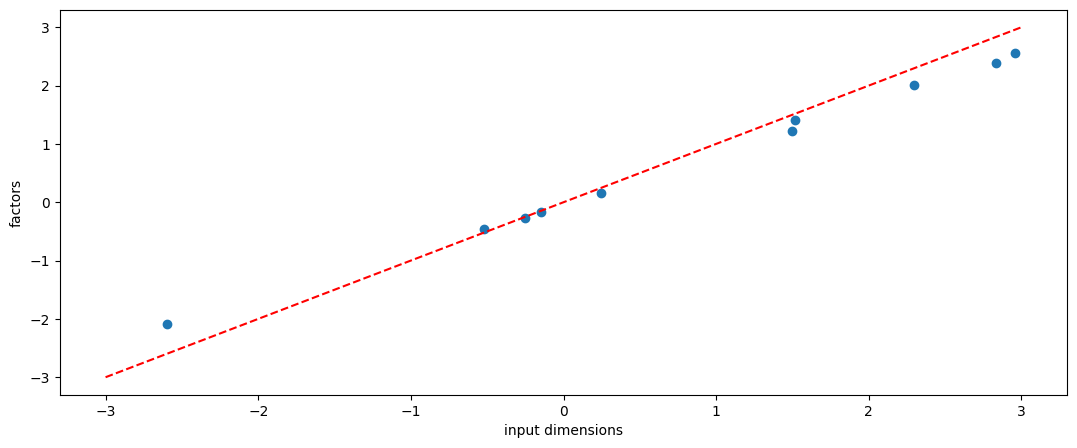

In [27]:
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot([-3, 3], [-3, 3], 'r--')
#ax.plot(logistic_model.linear.bias.detach().numpy(), 'r')
# ax.plot(W[-1, :], 'r--')
ax.scatter(logistic_model.linear.bias.detach().numpy(), W[-1, :])
ax.set_xlabel('input dimensions')
ax.set_ylabel('factors')

In [28]:
logistic_model.linear.weight.detach().numpy().shape, logistic_model.linear.weight.detach().numpy().ravel().shape, W[:-1, :].shape, W[:-1, :].ravel().shape

((10, 256), (2560,), (256, 10), (2560,))

Text(0, 0.5, 'factors')

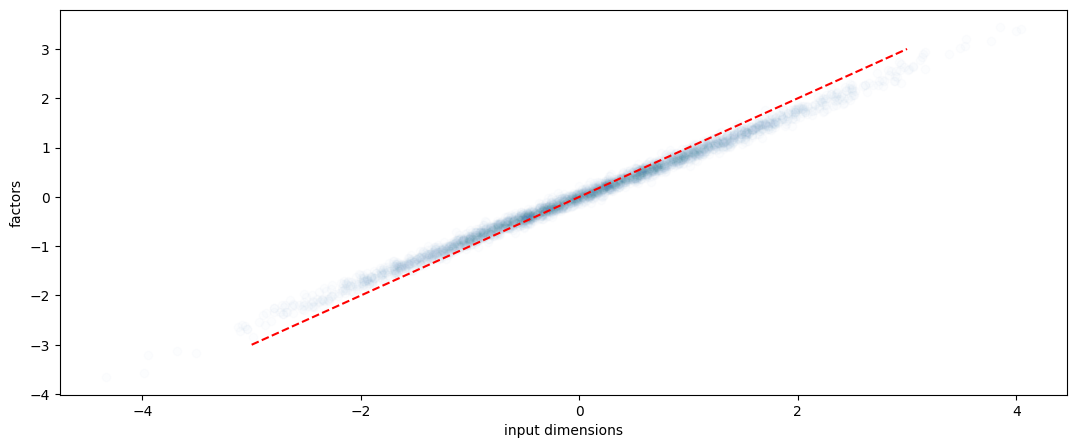

In [29]:
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot([-3, 3], [-3, 3], 'r--')
ax.scatter(logistic_model.linear.weight.detach().numpy().T.ravel(), W[:-1, :].ravel(), alpha=.01)
ax.set_xlabel('input dimensions')
ax.set_ylabel('factors')

In [30]:
torch.optim.Adam?

Init signature:
torch.optim.Adam(
    params,
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0,
    amsgrad=False,
    *,
    foreach: Optional[bool] = None,
    maximize: bool = False,
    capturable: bool = False,
    differentiable: bool = False,
    fused: Optional[bool] = None,
)
Docstring:     
Implements Adam algorithm.

.. math::
   \begin{aligned}
        &\rule{110mm}{0.4pt}                                                                 \\
        &\textbf{input}      : \gamma \text{ (lr)}, \beta_1, \beta_2
            \text{ (betas)},\theta_0 \text{ (params)},f(\theta) \text{ (objective)}          \\
        &\hspace{13mm}      \lambda \text{ (weight decay)},  \: \textit{amsgrad},
            \:\textit{maximize}                                                              \\
        &\textbf{initialize} :  m_0 \leftarrow 0 \text{ ( first moment)},
            v_0\leftarrow 0 \text{ (second moment)},\: \widehat{v_0}^{max}\leftarrow 0\\[-1.ex]
        &

## Logistic regression with Nans



### generative model for the data

In [81]:
N = 256 # number of factors
n_classes = 10 # number of classes
N_batch = 4

p_NaN = .05 # percentage of NaNs

def get_data(W, seed, N_batch, p_NaN):
    N, n_classes = W.shape[0]-1, W.shape[1]
    np.random.seed(seed)
    factors = np.random.randn(N_batch, N)
    p = psychometric_function(W, factors)
    y = (p > np.random.rand(N_batch, n_classes))  # generate data
    y = y.astype(float)
    y[np.random.rand(N_batch, n_classes)<p_NaN] = np.NaN  # generate data
    return factors, p, y

factors, p, y = get_data(W, seed, N_batch, p_NaN)
factors.shape, y.shape

(257, 10) (4, 256)


((4, 256), (4, 10))

In [ ]:
yy = y[0, :4].copy()
yy = yy.astype(float)

In [80]:
yy


array([nan,  1.,  1.,  1.])

In [79]:
yy[0] *= np.nan

In [50]:
p_NaN

0.05

In [53]:
(np.random.rand(N_batch, n_classes)<p_NaN).shape

((4, 10), (10000, 10))

In [63]:
y[np.random.rand(N_batch, n_classes)<.99] = np.NaN  # generate data
y[0, :]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [61]:
np.random.rand(N_batch, n_classes)<p_NaN

array([[False, False, False, False, False, False, False, False, False,
        False],
       [False, False,  True, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False],
       [False, False, False, False, False, False, False, False, False,
        False]])

### inference model

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
# see https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html#pytorch-loss-input-confusion-cheatsheet
criterion = torch.nn.BCELoss(reduction="mean") # loss divided by output size
#criterion = torch.nn.NLLLoss(reduction="mean") # loss divided by output size

class LogisticRegressionModel(torch.nn.Module):
    #torch.nn.Module -> Base class for all neural network modules
    def __init__(self, N, n_classes, bias=True):
        super(LogisticRegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(N, n_classes, bias=bias)
        # self.nl = torch.nn.LogSoftmax(n_classes)
        self.nl = torch.nn.Sigmoid()

    def forward(self, factors):
        return self.nl(self.linear(factors))

/opt/homebrew/lib/python3.11/site-packages/torch/__init__.py:615: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [ ]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1
batch_size = 256
n_classes=10
amsgrad = True  # gives similar results
amsgrad = False # gives similar results

def fit_data(factors, y, 
            learning_rate=learning_rate,
            batch_size=batch_size,  # gamma=gamma,
            num_epochs=num_epochs,
            betas=betas,
            verbose=False, **kwargs
        ):

    X, labels = torch.Tensor(factors[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(X, labels), batch_size=batch_size, shuffle=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    N_batch = factors.shape[0]
    N = factors.shape[1]
    n_classes = y.shape[1]
    logistic_model = LogisticRegressionModel(N, n_classes)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        logistic_model.train()
        losses = []
        for X_, labels_ in loader:
            X_, labels_ = X_.to(device), labels_.to(device)
            outputs = logistic_model(X_)
            loss = criterion(outputs, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    logistic_model.eval()
    X, labels = torch.Tensor(factors[:, None]), torch.Tensor(y[:, None])
    outputs = logistic_model(X)
    loss = criterion(outputs, labels).item()
    return logistic_model, loss


factors, p, y = get_data(W, seed=seed, N_batch=10000)
logistic_model, loss = fit_data(factors, y, verbose=True)
print("Final loss =", loss)

(257, 10) (10000, 256)
Iteration: 0 - Loss: 0.51636
Iteration: 16 - Loss: 0.11765
Iteration: 32 - Loss: 0.09548
Iteration: 48 - Loss: 0.08715
Iteration: 64 - Loss: 0.07998
Iteration: 80 - Loss: 0.07838
Iteration: 96 - Loss: 0.07634
Iteration: 112 - Loss: 0.07440
Iteration: 128 - Loss: 0.07364
Iteration: 144 - Loss: 0.07401
Iteration: 160 - Loss: 0.07278
Iteration: 176 - Loss: 0.07134
Iteration: 192 - Loss: 0.07057
Iteration: 208 - Loss: 0.07041
Iteration: 224 - Loss: 0.07118
Iteration: 240 - Loss: 0.06989
Iteration: 256 - Loss: 0.07129
Iteration: 272 - Loss: 0.07028
Iteration: 288 - Loss: 0.07074
Iteration: 304 - Loss: 0.07079
Iteration: 320 - Loss: 0.07061
Iteration: 336 - Loss: 0.07041
Iteration: 352 - Loss: 0.06959
Iteration: 368 - Loss: 0.06866
Iteration: 384 - Loss: 0.07056
Iteration: 400 - Loss: 0.06869
Iteration: 416 - Loss: 0.07027
Iteration: 432 - Loss: 0.06897
Iteration: 448 - Loss: 0.06947
Iteration: 464 - Loss: 0.06891
Iteration: 480 - Loss: 0.06865
Iteration: 496 - Loss: 0

Text(0, 0.5, 'factors')

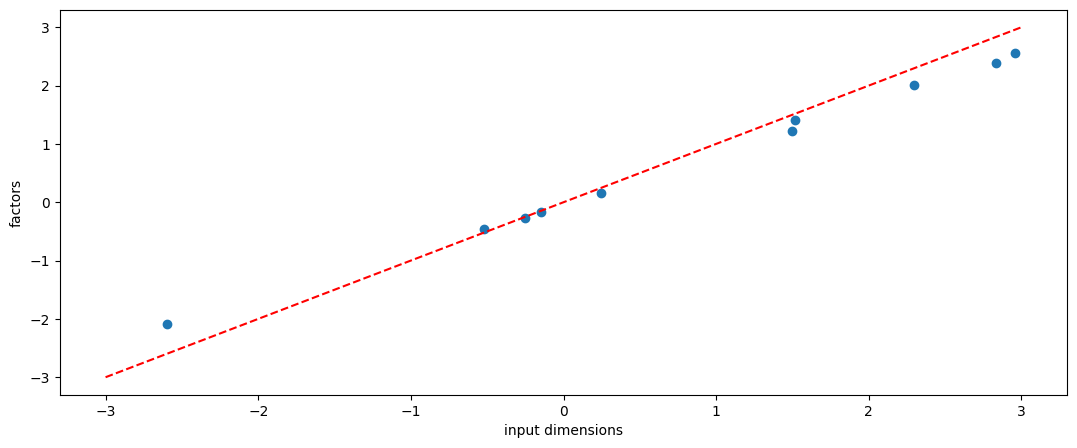

In [ ]:
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot([-3, 3], [-3, 3], 'r--')
#ax.plot(logistic_model.linear.bias.detach().numpy(), 'r')
# ax.plot(W[-1, :], 'r--')
ax.scatter(logistic_model.linear.bias.detach().numpy(), W[-1, :])
ax.set_xlabel('input dimensions')
ax.set_ylabel('factors')

In [ ]:
logistic_model.linear.weight.detach().numpy().shape, logistic_model.linear.weight.detach().numpy().ravel().shape, W[:-1, :].shape, W[:-1, :].ravel().shape

((10, 256), (2560,), (256, 10), (2560,))

Text(0, 0.5, 'factors')

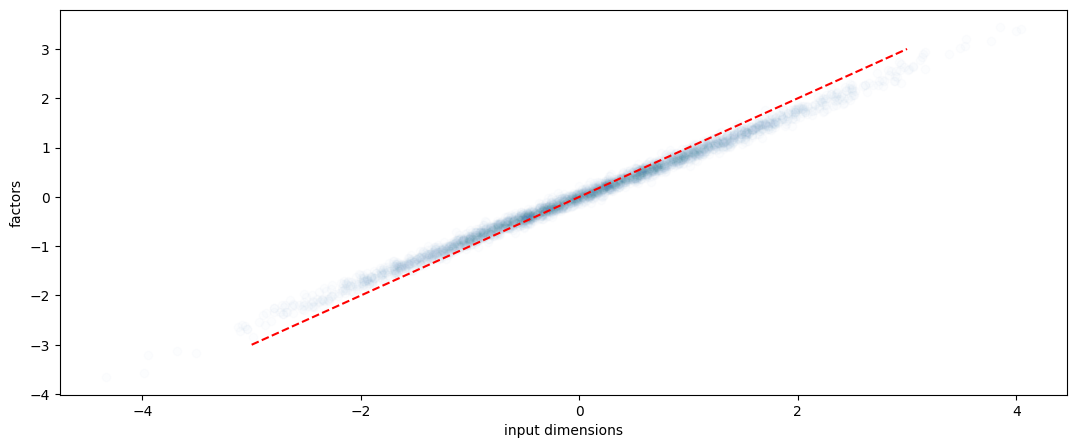

In [ ]:
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot([-3, 3], [-3, 3], 'r--')
ax.scatter(logistic_model.linear.weight.detach().numpy().T.ravel(), W[:-1, :].ravel(), alpha=.01)
ax.set_xlabel('input dimensions')
ax.set_ylabel('factors')

In [ ]:
torch.optim.Adam?

Init signature:
torch.optim.Adam(
    params,
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0,
    amsgrad=False,
    *,
    foreach: Optional[bool] = None,
    maximize: bool = False,
    capturable: bool = False,
    differentiable: bool = False,
    fused: Optional[bool] = None,
)
Docstring:     
Implements Adam algorithm.

.. math::
   \begin{aligned}
        &\rule{110mm}{0.4pt}                                                                 \\
        &\textbf{input}      : \gamma \text{ (lr)}, \beta_1, \beta_2
            \text{ (betas)},\theta_0 \text{ (params)},f(\theta) \text{ (objective)}          \\
        &\hspace{13mm}      \lambda \text{ (weight decay)},  \: \textit{amsgrad},
            \:\textit{maximize}                                                              \\
        &\textbf{initialize} :  m_0 \leftarrow 0 \text{ ( first moment)},
            v_0\leftarrow 0 \text{ (second moment)},\: \widehat{v_0}^{max}\leftarrow 0\\[-1.ex]
        &